In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA 
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
SYMBOL

{'XAUUSD': {'H4': 'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
  'D1': 'XAUUSD/XAUUSD_D1 - XAUUSD_D1'}}

In [91]:
XAUUSD = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] +'.csv',index_col='Time',parse_dates=True)
XAUUSD.index.name = None

In [92]:
start_date = '2007-01-01'
end_date = '2018-03-10'

In [93]:
XAUUSD =  XAUUSD.loc[start_date:end_date]

In [94]:
XAUUSD

,Open,High,Low,Close,Volume
2007-01-01 00:00:00,635.679,636.194,635.009,635.497,95
2007-01-01 04:00:00,635.336,636.220,635.254,635.699,97
2007-01-01 08:00:00,635.780,636.225,635.201,635.993,99
2007-01-01 12:00:00,636.053,636.189,635.117,636.006,90
2007-01-01 16:00:00,635.902,636.185,635.006,635.989,96
...,...,...,...,...,...
2018-03-09 04:00:00,1317.791,1319.442,1316.991,1318.752,240
2018-03-09 08:00:00,1318.769,1320.891,1317.949,1320.081,240
2018-03-09 12:00:00,1320.159,1324.081,1312.829,1322.329,240
2018-03-09 16:00:00,1322.428,1325.118,1320.911,1323.381,240


In [18]:
XAUUSD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1928 entries, 2007-01-01 00:00:00 to 2008-03-10 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1928 non-null   float64
 1   High    1928 non-null   float64
 2   Low     1928 non-null   float64
 3   Close   1928 non-null   float64
 4   Volume  1928 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 90.4 KB


In [19]:
def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose',
                   'Low-PrevClose']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis=1)
    return df

In [82]:
class Momentum(Strategy) :
    ATR_SL = 7
    max_dir_count = 5
    def init(self):
        self.data.df['ATR'] = ATR(self.data.df, 20)['ATR']
        self.data.df['direction'] = np.where(self.data.Close > self.data.Open, 'bull', 'bear')
        self.data.df['dir_count'] = self.data.df.groupby((self.data.df['direction'] != self.data.df['direction'].shift(1)).cumsum()).cumcount()+1
    

    def next(self):
        current_dir_count = self.data.df.loc[self.data.df.index[-1], 'dir_count']
        current_direction = self.data.df.loc[self.data.df.index[-1], 'direction']
        current_ATR = self.data.df.loc[self.data.df.index[-1], 'ATR']
        
        if current_dir_count >= self.max_dir_count and current_direction == 'bull' and not self.position and not np.isnan(current_ATR):
            if self.position.is_long :
                print('Have a order')
            tp = self.data.Close[-1] + current_ATR * self.ATR_SL
            sl = self.data.Open[-1]
                # Place your buy logic here
            self.buy(sl=sl, tp=tp,size=0.01)
        if current_dir_count >= self.max_dir_count and current_direction == 'bear' and not self.position and not np.isnan(current_ATR):
            tp = self.data.Close[-1] - current_ATR * self.ATR_SL
            sl = self.data.Open[-1]
            
            self.sell(sl=sl, tp=tp ,size=0.01)  # Place your buy logic here

In [95]:
bt = Backtest(XAUUSD, Momentum, cash=200, margin=1/2000, )
start = bt.run()
start

C:\Users\Win10\AppData\Local\Temp\ipykernel_7772\2636292555.py:1: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(XAUUSD, Momentum, cash=200, margin=1/2000, )


Start                     2007-01-01 00:00:00
End                       2018-03-09 20:00:00
Duration                   4085 days 20:00:00
Exposure Time [%]                    8.812239
Equity Final [$]                      51.6887
Equity Peak [$]                      4697.926
Return [%]                          -74.15565
Buy & Hold Return [%]              108.169197
Return (Ann.) [%]                   -9.315599
Volatility (Ann.) [%]               84.439594
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.899755
Avg. Drawdown [%]                  -14.968831
Max. Drawdown Duration     3637 days 20:00:00
Avg. Drawdown Duration       89 days 04:00:00
# Trades                                  202
Win Rate [%]                          9.90099
Best Trade [%]                       8.472047
Worst Trade [%]                     -2.136343
Avg. Trade [%]                    

In [23]:
start['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,6,93,93,634.922,634.57100,-2.10600,-0.000553,2007-01-22 00:00:00,2007-01-22 00:00:00,0 days 00:00:00
1,6,94,94,635.716,634.92200,-4.76400,-0.001249,2007-01-22 04:00:00,2007-01-22 04:00:00,0 days 00:00:00
2,5,103,233,644.954,673.79790,144.21950,0.044722,2007-01-23 16:00:00,2007-02-21 16:00:00,29 days 00:00:00
3,-10,259,282,669.399,632.80950,365.89500,0.054660,2007-02-27 20:00:00,2007-03-05 12:00:00,5 days 16:00:00
4,21,330,330,644.107,643.98600,-2.54100,-0.000188,2007-03-15 08:00:00,2007-03-15 08:00:00,0 days 00:00:00
5,21,331,331,645.448,644.10700,-28.16100,-0.002078,2007-03-15 12:00:00,2007-03-15 12:00:00,0 days 00:00:00
6,20,332,332,647.901,645.44800,-49.06000,-0.003786,2007-03-15 16:00:00,2007-03-15 16:00:00,0 days 00:00:00
7,19,343,343,655.204,655.20400,0.00000,0.000000,2007-03-19 08:00:00,2007-03-19 08:00:00,0 days 00:00:00
8,18,420,421,673.423,672.49700,-16.66800,-0.001375,2007-04-04 20:00:00,2007-04-05 00:00:00,0 days 04:00:00
9,18,427,427,674.214,674.12300,-1.63800,-0.000135,2007-04-06 00:00:00,2007-04-06 00:00:00,0 days 00:00:00


In [ ]:
def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

In [25]:
trade = start['_trades'].copy()


In [46]:
trade['result'] = np.where(
    trade['Size'] > 0, (trade['ExitPrice'] - trade['EntryPrice']) * 50, (trade['EntryPrice'] - trade['ExitPrice']) * 50)

In [47]:
trade['cum_res'] = trade['result'].cumsum() + 100

In [55]:
returns = trade['cum_res'].pct_change()
volatility = returns.std() * np.sqrt(252)
sharpe_ratio = round((returns.mean() - 0.02) / volatility, 2)

In [52]:
returns.mean()

0.6895959012703474

In [57]:
sharpe_ratio

0.01

In [54]:
trade

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,result,cum_res
0,6,93,93,634.922,634.57100,-2.10600,-0.000553,2007-01-22 00:00:00,2007-01-22 00:00:00,0 days 00:00:00,-17.5500,82.4500
1,6,94,94,635.716,634.92200,-4.76400,-0.001249,2007-01-22 04:00:00,2007-01-22 04:00:00,0 days 00:00:00,-39.7000,42.7500
2,5,103,233,644.954,673.79790,144.21950,0.044722,2007-01-23 16:00:00,2007-02-21 16:00:00,29 days 00:00:00,1442.1950,1484.9450
3,-10,259,282,669.399,632.80950,365.89500,0.054660,2007-02-27 20:00:00,2007-03-05 12:00:00,5 days 16:00:00,1829.4750,3314.4200
4,21,330,330,644.107,643.98600,-2.54100,-0.000188,2007-03-15 08:00:00,2007-03-15 08:00:00,0 days 00:00:00,-6.0500,3308.3700
5,21,331,331,645.448,644.10700,-28.16100,-0.002078,2007-03-15 12:00:00,2007-03-15 12:00:00,0 days 00:00:00,-67.0500,3241.3200
6,20,332,332,647.901,645.44800,-49.06000,-0.003786,2007-03-15 16:00:00,2007-03-15 16:00:00,0 days 00:00:00,-122.6500,3118.6700
7,19,343,343,655.204,655.20400,0.00000,0.000000,2007-03-19 08:00:00,2007-03-19 08:00:00,0 days 00:00:00,0.0000,3118.6700
8,18,420,421,673.423,672.49700,-16.66800,-0.001375,2007-04-04 20:00:00,2007-04-05 00:00:00,0 days 04:00:00,-46.3000,3072.3700
9,18,427,427,674.214,674.12300,-1.63800,-0.000135,2007-04-06 00:00:00,2007-04-06 00:00:00,0 days 00:00:00,-4.5500,3067.8200


In [26]:
bt.plot()

Row(id='1407', ...)

In [96]:
optimize, heatmap =  bt.optimize(
    ATR_SL = range(1,12,1),
    max_dir_count = range(1,10,1),
    maximize='Sharpe Ratio',
    return_heatmap= True

)

  0%|          | 0/9 [00:00<?, ?it/s]

ValueError: Short orders require: TP (1608.88465) < LIMIT (1615.414) < SL (1615.414)

In [89]:
optimize

Start                     2007-01-01 00:00:00
End                       2008-03-10 20:00:00
Duration                    434 days 20:00:00
Exposure Time [%]                    16.59751
Equity Final [$]                     1954.644
Equity Peak [$]                      1954.644
Return [%]                            877.322
Buy & Hold Return [%]               53.168937
Return (Ann.) [%]                  366.522547
Volatility (Ann.) [%]              695.469831
Sharpe Ratio                         0.527014
Sortino Ratio                        7.577781
Calmar Ratio                         6.478523
Max. Drawdown [%]                  -56.575018
Avg. Drawdown [%]                  -13.572418
Max. Drawdown Duration      130 days 20:00:00
Avg. Drawdown Duration       15 days 05:00:00
# Trades                                   61
Win Rate [%]                        18.032787
Best Trade [%]                       3.898796
Worst Trade [%]                     -1.130007
Avg. Trade [%]                    

In [28]:
optimize['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,6,93,93,634.922,634.57100,-2.10600,-0.000553,2007-01-22 00:00:00,2007-01-22 00:00:00,0 days 00:00:00
1,6,94,94,635.716,634.92200,-4.76400,-0.001249,2007-01-22 04:00:00,2007-01-22 04:00:00,0 days 00:00:00
2,5,103,233,644.954,673.79790,144.21950,0.044722,2007-01-23 16:00:00,2007-02-21 16:00:00,29 days 00:00:00
3,-10,259,282,669.399,632.80950,365.89500,0.054660,2007-02-27 20:00:00,2007-03-05 12:00:00,5 days 16:00:00
4,21,330,330,644.107,643.98600,-2.54100,-0.000188,2007-03-15 08:00:00,2007-03-15 08:00:00,0 days 00:00:00
5,21,331,331,645.448,644.10700,-28.16100,-0.002078,2007-03-15 12:00:00,2007-03-15 12:00:00,0 days 00:00:00
6,20,332,332,647.901,645.44800,-49.06000,-0.003786,2007-03-15 16:00:00,2007-03-15 16:00:00,0 days 00:00:00
7,19,343,343,655.204,655.20400,0.00000,0.000000,2007-03-19 08:00:00,2007-03-19 08:00:00,0 days 00:00:00
8,18,420,421,673.423,672.49700,-16.66800,-0.001375,2007-04-04 20:00:00,2007-04-05 00:00:00,0 days 04:00:00
9,18,427,427,674.214,674.12300,-1.63800,-0.000135,2007-04-06 00:00:00,2007-04-06 00:00:00,0 days 00:00:00


In [27]:
optimize['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
2007-01-01 00:00:00,200.000,0.000000,NaT
2007-01-01 04:00:00,200.000,0.000000,NaT
2007-01-01 08:00:00,200.000,0.000000,NaT
2007-01-01 12:00:00,200.000,0.000000,NaT
2007-01-01 16:00:00,200.000,0.000000,NaT
...,...,...,...
2008-03-10 04:00:00,3161.247,0.162115,NaT
2008-03-10 08:00:00,2805.432,0.256423,NaT
2008-03-10 12:00:00,2710.482,0.281589,NaT
2008-03-10 16:00:00,2937.147,0.221512,NaT


In [34]:
heatmap

ATR_SL  max_dir_count
1       1                 30.04335
        2                 31.95030
        3                 29.99210
        4                 29.99850
        5                 76.96435
                           ...    
11      5                288.23160
        6                 40.02400
        7                 51.69000
        8                 67.60200
        9                 73.65000
Name: Equity Final [$], Length: 99, dtype: float64

In [52]:
hm = heatmap.groupby(["ATR_SL","max_dir_count"]).mean().unstack()

In [53]:
hm

max_dir_count,1,2,3,4,5,6,7,8,9
ATR_SL,,,,,,,,,
1,30.04335,31.9503,29.99210,29.99850,76.96435,71.03985,73.57730,88.7303,73.65
2,25.10570,28.5262,31.55560,40.33650,84.49030,138.01510,76.93780,98.7366,73.65
3,24.38755,25.0415,31.76570,146.96710,200.30615,145.42280,88.12370,98.8329,73.65
4,30.16000,28.0852,30.06660,227.31120,357.09120,98.19520,68.60980,108.7082,73.65
5,31.19450,20.6590,24.96550,323.67850,855.39275,154.34700,73.37575,118.7145,73.65
6,24.97670,23.2894,28.49540,380.07030,855.70270,174.37860,78.14170,67.6020,73.65
7,26.54480,24.1198,31.11230,797.14185,1299.18675,226.76385,51.69000,67.6020,73.65
8,30.55460,30.8062,31.63820,703.56760,951.85140,336.53640,51.69000,67.6020,73.65
9,26.67290,24.3056,32.03160,243.99975,730.04955,271.12905,51.69000,67.6020,73.65


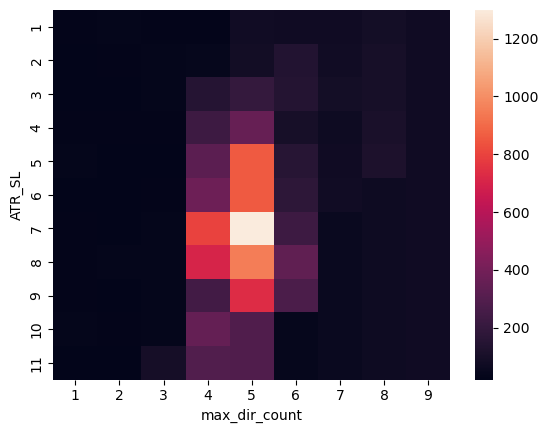

In [56]:
sns.heatmap(hm)
plt.show()

In [61]:
plot_heatmaps(heatmap, agg='mean',filename='../Strategy+8+-+Momentum.ipynb/Momentum_plot_heatmaps_.html')

Column(id='5715', ...)

In [31]:
bt.plot()

Row(id='4467', ...)